In [1]:
# importing libraries required to train an image classifier based on the Fine-tuned Swin Transformer
import os
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import timm
import json
import shutil
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from torch.optim.lr_scheduler import StepLR

In [2]:
# verifying the availability of the GPUs
if torch.cuda.is_available():
    device = "cuda"
    print(f"PyTorch detected: {torch.cuda.get_device_name(0)} for processing.. ")
    print(f"Numbe of GPUs found: {torch.cuda.device_count()}")
    device = torch.device("cuda") # if there are multiple GPUs assign the Device Id
    cudnn.benchmark = True
    torch.cuda.empty_cache() # clear the CUDA cache from the system
else:
    device = "cpu"

PyTorch detected: NVIDIA GeForce RTX 4090 for processing.. 
Numbe of GPUs found: 1


In [3]:
current_path = os.getcwd()
dataset_dir_path = r"D:\PhD\Year - IV\Datasets\private\species_dataset"
train_dir_path = os.path.join(dataset_dir_path, 'train_data')
test_dir_path = os.path.join(dataset_dir_path, 'test_data')
label_file_path = os.path.join(dataset_dir_path, 'label_map.txt')
output_dir_path = os.path.join(current_path, 'output', 'Vision_Transformer')

In [4]:
# loading label_map.txt file to map the class names
with open(label_file_path, 'r') as file:
    label_mapping = json.load(file)
print(label_mapping)

{'Australian magpie': 0, 'Australian owlet-nightjar': 1, 'Black bird': 2, 'Black rat': 3, 'Brown treecreeper': 4, 'Brush-tailed phascogale': 5, 'Cat': 6, 'Common bronzewing': 7, 'Common brushtail possum': 8, 'Corvids': 9, 'Cow': 10, 'Deer': 11, 'Dog': 12, 'Eastern grey kangaroo': 13, 'European hare': 14, 'Grey currawong': 15, 'House mouse': 16, 'Koala': 17, 'Painted button-quail': 18, 'Red fox': 19, 'Short-beaked echidna': 20, 'Starling': 21, 'Superb fairy-wren': 22, 'Swamp wallaby': 23, 'White-winged chough': 24, 'Willie wagtail': 25, 'Wombat': 26, 'Yellow-footed antechinus': 27}


In [5]:
inverted_label_mapping = {v: k for k, v in label_mapping.items()}

In [8]:
print(timm.list_models('vit_*')) # list all the pool former architectres

['vit_base_mci_224', 'vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_reg1_gap_256', 'vit_base_patch16_rpn_224', 'vit_base_patch16_siglip_224', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_384', 'vit_base_patch16_siglip_512', 'vit_base_patch16_siglip_gap_224', 'vit_base_patch16_siglip_gap_256', 'vit_base_patch16_siglip_gap_384', 'vit_base_patch16_siglip_gap_512', 'vit_base_patch16_xp_224', 'vit_base_patch32_224', 'vit_base_patch32_384', 'vit_base_patch32_clip_224', 'vit_base_patch32_clip_256', 'vit_base_patch32_clip_384', 'vit_base_patch32_clip_448', 'vit_base_patch32_clip_quickgelu_224', 'vit_base_patch32_plus_256', 'vit_base_r26_s

In [9]:
# load the architecture selected from the above output
arch_info = 'vit_base_patch16_224'
swin_model = timm.create_model(arch_info, pretrained=True) # pre-trained on ImageNet 1k

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
print(swin_model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [11]:
# adjust the batch size based on the GPU size
BATCH_SIZE = 32 # number of images used to load and process in a single job request

In [12]:
# Define data augmentation and normalization steps based on the model architecture
IMAGE_SIZE = 224  # image size used by the swin transformer

# Define data augmentation and normalization steps for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Define normalization steps for validation and test data
val_test_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize images to 256 pixels
    transforms.CenterCrop(IMAGE_SIZE),  # Crop the center 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

In [13]:
custom_dataset = datasets.ImageFolder(root=train_dir_path, transform=train_transforms)

In [14]:
# splitting the dataset loaded from the directory to train, test and val data
TRAIN_RATIO = 0.8  # 80% of data
VAL_RATIO = 0.2    # 20% of data
train_dataset, val_dataset = torch.utils.data.random_split(custom_dataset, [TRAIN_RATIO, VAL_RATIO])

In [15]:
test_dataset = datasets.ImageFolder(root=test_dir_path, transform=val_test_transforms)

In [16]:
# load the split dataset using data loader for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

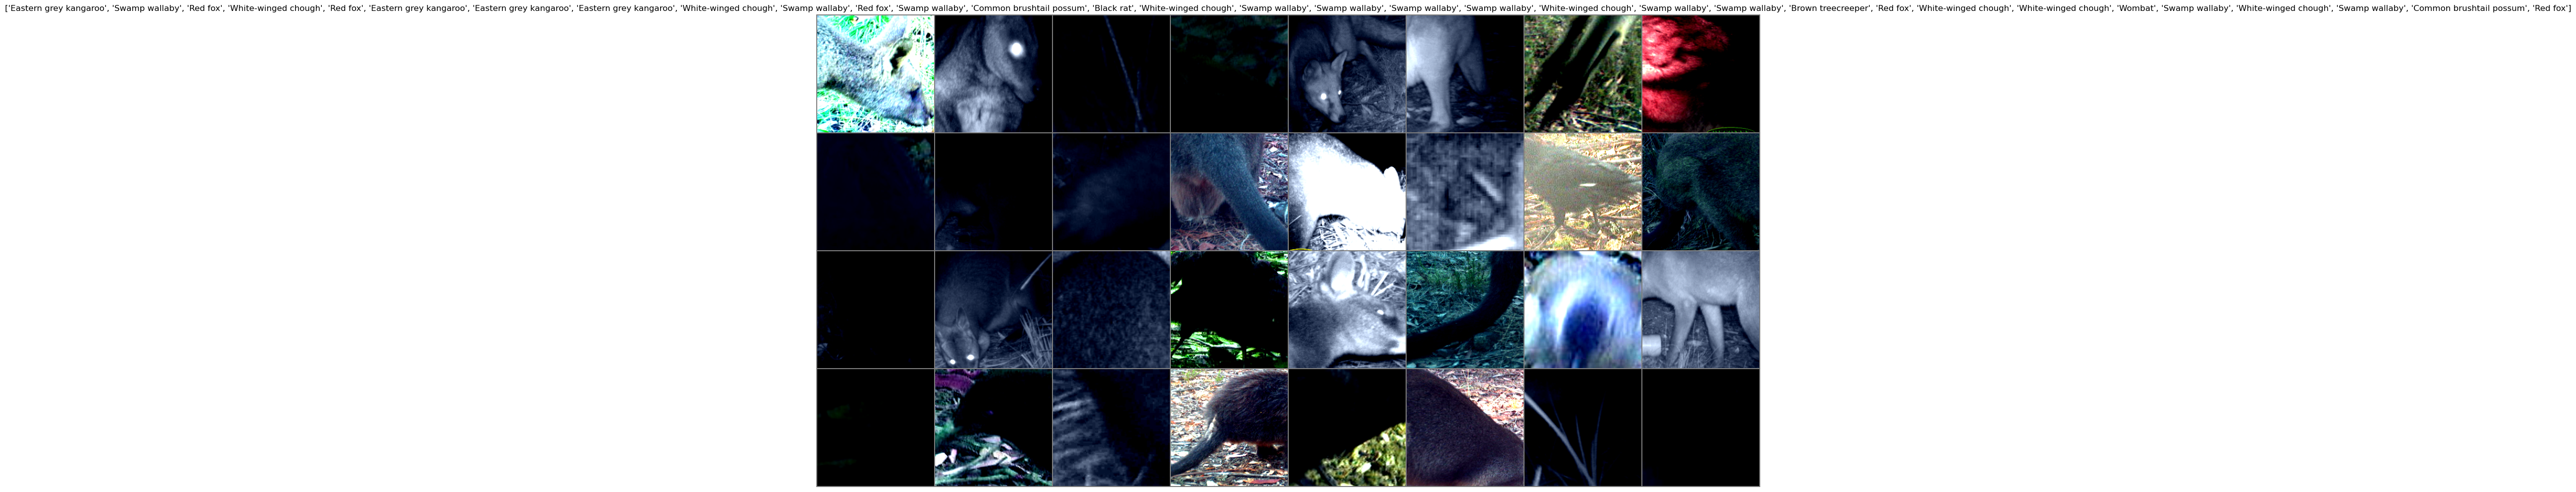

In [17]:
# verify the multi image dataset loader
def show_image_batch(image_batch, labels):
    # Create a grid of images
    img = utils.make_grid(image_batch, nrow=8)  # Adjust nrow to the number of images you want per row
    img = img / 2 + 0.5  # Normalize to [0, 1]
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # Clip to [0, 1] range
    plt.figure(figsize=(20, 10))  # Increase the figure size if necessary
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    label_str = [inverted_label_mapping[label.item()] for label in labels]
    plt.title(label_str)  # Set the string label as the title
    plt.tight_layout()
    plt.show()

# Fetch the first batch of images
dataiter = iter(train_loader)
image_batch, labels = next(dataiter)

# Call the function to display the batch and save it in a png file
show_image_batch(image_batch, labels)

In [18]:
# updating the model architecture to support the custom class labels
# Fine-tuning the model architecture for training
# Replace the fully connected layer in the classifier head
#swin_model.head.fc = nn.Linear(in_features=swin_model.head.fc.in_features, out_features=len(label_mapping))
swin_model.head = nn.Linear(in_features=swin_model.head.in_features, out_features=len(label_mapping))

# Move the model to the appropriate device (GPU or CPU)
swin_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [19]:
def create_directory(dir_path):
    try:
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
    except OSError as oer:
        print(oer)
        raise

In [20]:
output_dir_path = os.path.join(output_dir_path, arch_info)
create_directory(output_dir_path)
output_model_path = os.path.join(output_dir_path, f'{arch_info}_general_model.pth')

In [21]:
# part - II hyper parameters used for training the model: defining the loss function and optimizer
criterion = nn.CrossEntropyLoss() # suitalbel for multi-class classification task

# Initialize the Adam optimizer with weight decay
optimizer = optim.Adam(swin_model.parameters(), lr=0.0001, weight_decay=1e-5)

# Define a learning rate scheduler (e.g., StepLR for step decay)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
def evaluate_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

In [23]:
def validate_model(model, val_dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
    
    avg_loss = val_loss / len(val_dataloader)
    accuracy = correct / len(val_dataloader.dataset)
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return accuracy

In [24]:
# Training functions
def train_model(model, train_dataloader, criterion, optimizer, device):
    model.train()
    # Training step
    total_loss = 0.0
    total_samples = 0
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update total loss and total number of samples processed
        batch_loss = loss.item() * inputs.size(0)
        total_loss += batch_loss
        total_samples += inputs.size(0)

        # Optional: Print batch loss every N batches
        if batch_idx % 100 == 99:  # prints every 100 batches
            print(f'Batch {batch_idx + 1}, Batch Loss: {batch_loss / inputs.size(0):.4f}')
    
    # Calculate average loss over the entire training dataset
    epoch_loss = total_loss / total_samples
    print(f'Overall training loss for the epoch: {epoch_loss:.4f}')

In [25]:
# Training Loop
num_epochs = 100
best_val_accuracy = 0.0
patience = 5  # Number of epochs to wait for improvement
no_improvement_count = 0


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_model(swin_model, train_loader, criterion, optimizer, device)
    val_accuracy = validate_model(swin_model, val_loader, criterion, device)

    # Check for improvement in validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_count = 0
        # Save the model if it's the best so far
        torch.save(swin_model.state_dict(), output_model_path)
    else:
        no_improvement_count += 1
    
    # Early stopping if no improvement in validation accuracy
    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break
    
    # Evaluate on test data every 5 epochs
    if ((epoch == 0) or ((epoch + 1) % 5 == 0)):
        evaluate_model(swin_model, test_loader, device)
        
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate for this epoch: {current_lr}')


print('Finished Training')

Epoch 1/100


C:\Users\Sameer\anaconda3\envs\EnhancedSwinTransformer\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Batch 100, Batch Loss: 0.3331
Batch 200, Batch Loss: 0.5882
Batch 300, Batch Loss: 0.7116
Batch 400, Batch Loss: 0.7124
Overall training loss for the epoch: 0.8524
Validation Loss: 15.8002, Accuracy: 0.8400
Accuracy on test set: 89.89%
Current learning rate for this epoch: 0.0001
Epoch 2/100
Batch 100, Batch Loss: 0.3707
Batch 200, Batch Loss: 0.1951
Batch 300, Batch Loss: 0.5438
Batch 400, Batch Loss: 0.3248
Overall training loss for the epoch: 0.4752
Validation Loss: 12.7007, Accuracy: 0.8709
Current learning rate for this epoch: 0.0001
Epoch 3/100
Batch 100, Batch Loss: 0.6636
Batch 200, Batch Loss: 0.5413
Batch 300, Batch Loss: 0.3359
Batch 400, Batch Loss: 0.3699
Overall training loss for the epoch: 0.3987
Validation Loss: 13.1023, Accuracy: 0.8655
Current learning rate for this epoch: 0.0001
Epoch 4/100
Batch 100, Batch Loss: 0.4955
Batch 200, Batch Loss: 0.2126
Batch 300, Batch Loss: 0.2997
Batch 400, Batch Loss: 0.2539
Overall training loss for the epoch: 0.3689
Validation Loss

In [26]:
# load the model saved from the fine-tuning
swin_model.load_state_dict(torch.load(output_model_path))
swin_model.eval()  # Set the model to evaluation mode
swin_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [27]:
true_labels_list = []
pred_labels_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # fetching ground truth label names
        label_names = [inverted_label_mapping[label.item()] for label in labels]
        # print(label_names)
        
        outputs = swin_model(inputs)
        # Apply softmax to convert outputs to probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
        # Get the predicted class indices
        _, predicted_indices = torch.max(probabilities, dim=1)
    
        # Get the confidence scores for the predictions
        confidence_scores = probabilities[torch.arange(probabilities.size(0)), predicted_indices]
    
        # Convert predicted class indices to actual labels
        predicted_labels = [inverted_label_mapping[idx.item()] for idx in predicted_indices]
    
        # Print the results
        for true_label, pred_label, score in zip(label_names, predicted_labels, confidence_scores):
            true_labels_list.append(true_label)
            pred_labels_list.append(pred_label)
            print(f"Ground truth: {true_label} Predicted label: {pred_label}, Confidence score: {score.item():.4f}")

Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 0.9999
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 0.9999
Ground truth: Australian magpie Predicted label: Australian magpie, Confidence score: 1.0000
Ground truth: Australian magpie Predicted label: Australian magpie, Co

In [28]:
# printing classification report of each labels
classification_report_data = classification_report(true_labels_list, pred_labels_list, digits=4)
print(classification_report_data)
class_accuracy_dict = classification_report(true_labels_list, pred_labels_list, digits=4, output_dict=True)

                           precision    recall  f1-score   support

        Australian magpie     0.9834    0.9570    0.9700       186
Australian owlet-nightjar     0.0000    0.0000    0.0000         1
               Black bird     0.9091    0.8333    0.8696        12
                Black rat     0.8214    0.8679    0.8440        53
        Brown treecreeper     0.9375    0.9375    0.9375        16
  Brush-tailed phascogale     0.9524    0.9524    0.9524        21
                      Cat     0.8235    0.7778    0.8000        18
        Common bronzewing     0.9167    1.0000    0.9565        22
  Common brushtail possum     0.9900    0.9737    0.9818       609
                  Corvids     1.0000    0.9603    0.9798       126
                      Cow     0.8333    0.7143    0.7692         7
                     Deer     0.8571    0.9474    0.9000        19
                      Dog     0.8072    0.8481    0.8272        79
    Eastern grey kangaroo     0.9668    0.9823    0.9745     

C:\Users\Sameer\anaconda3\envs\EnhancedSwinTransformer\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sameer\anaconda3\envs\EnhancedSwinTransformer\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sameer\anaconda3\envs\EnhancedSwinTransformer\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [29]:
# save the classification report into a CSV
df_classification_report = pd.DataFrame(class_accuracy_dict).transpose()
# storing the pandas data frame into a CSV
#print(df_classification_report)
csv_file_path = os.path.join(output_dir_path, f'{arch_info}_classification_accuracy.csv')
# saving the dataframe
df_classification_report.to_csv(csv_file_path)